In [201]:
import numpy as np
from scipy.stats import ttest_rel
import pandas as pd
import seaborn as sns
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
from matplotlib import pyplot as plt
from scipy.stats import ttest_rel, wilcoxon

In [202]:
def load_files(skip_mode, recalled, metric):
    
    if recalled:
        recall_str = "_recalled"
        skip_mode = [0,1] # automatically skip 0/1 (correct/not correct) for recalled trials
    else:
        recall_str = ""
    
    theta_pac_data = {f'{metric}': [], f'{metric}_z': [], 'p_val': [], 'subj': [], 'mode': [], 'gamma_type': []}
    subjects_by_mode = {}
    for i in range(4):
        if i in skip_mode:
            continue 
        
        subjects_by_mode[i] = []
        vals_hg = dict(np.load(f'saved_results/hg_{metric}_by_subj_{i}{recall_str}.npz'))
        vals_lg = dict(np.load(f'saved_results/lg_{metric}_by_subj_{i}{recall_str}.npz'))
        
        vals_z_hg = dict(np.load(f'saved_results/hg_{metric}_by_subj_z_{i}{recall_str}.npz'))
        vals_z_lg = dict(np.load(f'saved_results/lg_{metric}_by_subj_z_{i}{recall_str}.npz'))
        
        p_vals_hg = dict(np.load(f'saved_results/hg_{metric}_p_vals_by_subj_{i}{recall_str}.npz'))
        p_vals_lg = dict(np.load(f'saved_results/lg_{metric}_p_vals_by_subj_{i}{recall_str}.npz'))
        

        for subj in vals_hg.keys():
            
            try:
                
                if metric == 'MI':
                    
                    hg_subj = vals_hg[subj][0]
                    lg_subj = vals_lg[subj][0]

                    hg_subj_z = vals_z_hg[subj][0]
                    lg_subj_z = vals_z_lg[subj][0]

                    hg_p_subj = p_vals_hg[subj][0]
                    lg_p_subj = p_vals_lg[subj][0]
                    
                elif metric == 'MOVI':
       
                    hg_subj = vals_hg[subj]
                    lg_subj = vals_lg[subj]

                    hg_subj_z = vals_z_hg[subj]
                    lg_subj_z = vals_z_lg[subj]

                    hg_p_subj = p_vals_hg[subj]
                    lg_p_subj = p_vals_lg[subj]
                    
                
                theta_pac_data[f'{metric}'].extend([hg_subj, lg_subj])
                theta_pac_data[f'{metric}_z'].extend([hg_subj_z, lg_subj_z])
                theta_pac_data['p_val'].extend([hg_p_subj, lg_p_subj])
                theta_pac_data['subj'].extend([subj, subj])
                theta_pac_data['mode'].extend([i, i])
                theta_pac_data['gamma_type'].extend(['hg', 'lg'])
                
                              
                subjects_by_mode[i].append(subj)
                
                
            except: 
                pass
        
    return pd.DataFrame(theta_pac_data), subjects_by_mode

In [203]:
theta_pac_pd, subjects_by_mode = load_files([0, 1], recalled=False, metric='MOVI')

In [204]:
def subjects_intersect(subj_dict, modes):
    
    s1 = subj_dict[modes[0]]
    s2 = subj_dict[modes[1]]  

    return np.intersect1d(s1, s2)

In [205]:
s_intersect_2_3 = subjects_intersect(subjects_by_mode, [2,3])
mask_2_3 = theta_pac_pd['subj'].isin(s_intersect_2_3)
theta_pac_pd_2_3 = theta_pac_pd[mask_2_3]

In [206]:
theta_pac_pd_2_3.head()

,MOVI,MOVI_z,p_val,subj,mode,gamma_type
0,8.722707594772234e-05,-0.18659764360549394,0.5,R1045E,2,hg
1,4.964726832586447e-05,-0.6164294900203316,0.6966666666666667,R1045E,2,lg
2,0.00015182675651473942,-0.40747876889828144,0.6166666666666667,R1061T,2,hg
3,0.00010433615481590914,-0.38238611953635226,0.5733333333333333,R1061T,2,lg
4,2.4510894932438012e-05,1.7429688757083506,0.053333333333333344,R1065J,2,hg


In [207]:
def compute_stats_test(gamma_type, PAC_SME_df, modes, y_val, tstat=False):
    
    PAC_SME_df_g = PAC_SME_df.loc[PAC_SME_df.gamma_type==gamma_type]
    
    if tstat: 
        
        t,p = ttest_rel(PAC_SME_df_g.loc[PAC_SME_df_g['mode']==modes[0]][y_val].values, 
        PAC_SME_df_g.loc[PAC_SME_df_g['mode']==modes[1]][y_val].values)

        return t,p
        
    
    else:
        res = wilcoxon(PAC_SME_df_g.loc[PAC_SME_df_g['mode']==modes[0]][y_val].values, 
        PAC_SME_df_g.loc[PAC_SME_df_g['mode']==modes[1]][y_val].values)

        return res.statistic, res.pvalue

In [208]:
compute_stats_test('hg', theta_pac_pd_2_3, [3,2], 'MOVI')

(39.0, 0.02298736572265625)

In [237]:
def generate_figures(theta_pac_data, y_val, modes):
    
    PAC_SME = theta_pac_data.groupby(['subj', 'mode', 'gamma_type'])[y_val].mean()
    
    PAC_SME_df = {'subj': [], 'mode': [], 'gamma_type': [],  y_val: []}
    for idx, val in zip (PAC_SME.index, PAC_SME.values):
        PAC_SME_df['subj'].append(idx[0])
        PAC_SME_df['mode'].append(idx[1])
        PAC_SME_df['gamma_type'].append(idx[2])
        PAC_SME_df[y_val].append(val)
        
    PAC_SME_df = pd.DataFrame(PAC_SME_df)
    
    t, p1 = compute_stats_test('hg', PAC_SME_df, modes, y_val, tstat=False)
    t, p2 = compute_stats_test('lg', PAC_SME_df, modes, y_val, tstat=False)
    
    fig, ax = plt.subplots(1,1, figsize=(10,6))
    sns.stripplot(data=PAC_SME_df,  x='gamma_type', y=y_val, hue='mode', size=6, dodge=True, ax=ax, legend=False, palette='tab10')
    for i in range(0, 4, 2):
        locs1 = ax.get_children()[i].get_offsets()
        locs2 = ax.get_children()[i+1].get_offsets()
        for i in range(locs1.shape[0]):
            x = [locs1[i, 0], locs2[i, 0]]
            y = [locs1[i, 1], locs2[i, 1]]
            ax.plot(x, y, color="black", alpha=0.15)
    
    
    if y_val == 'p_val':
        #ax.text(0, 0.57, f'P={round(p1,3)}', ha='center', va='bottom')
        #ax.text(1, 0.57, f'P={round(p2,3)}', ha='center', va='bottom')
        pass
    else:
        if y_val == 'MI':
            ax.text(0, 0.0034, f'P={round(p1,3)}', ha='center', va='bottom')
            ax.text(1, 0.0034, f'P={round(p2,3)}', ha='center', va='bottom')
        elif y_val == 'MOVI':
            ax.text(0, 0.0010, f'P={round(p1,3)}', ha='center', va='bottom')
            ax.text(1, 0.0010, f'P={round(p2,3)}', ha='center', va='bottom')
        elif y_val == 'MOVI_z':
            ax.text(0, 2.1, f'P={round(p1,3)}', ha='center', va='bottom')
            ax.text(1, 2.1, f'P={round(p2,3)}', ha='center', va='bottom')
        pass
    
    sns.boxplot(data=PAC_SME_df, x='gamma_type', y=y_val, hue='mode', fliersize=0, ax=ax, fill=False, palette='tab10')
        
    plt.show()


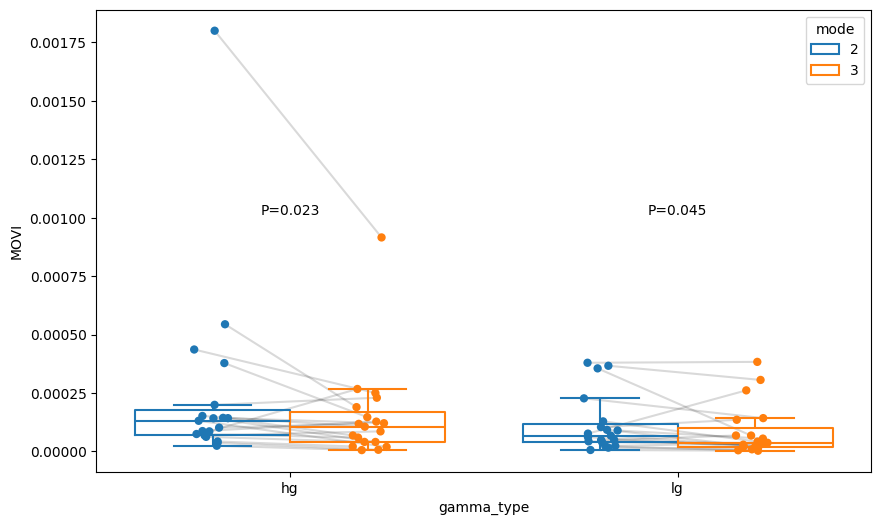

In [238]:
generate_figures(theta_pac_pd_2_3, 'MOVI', [2,3])

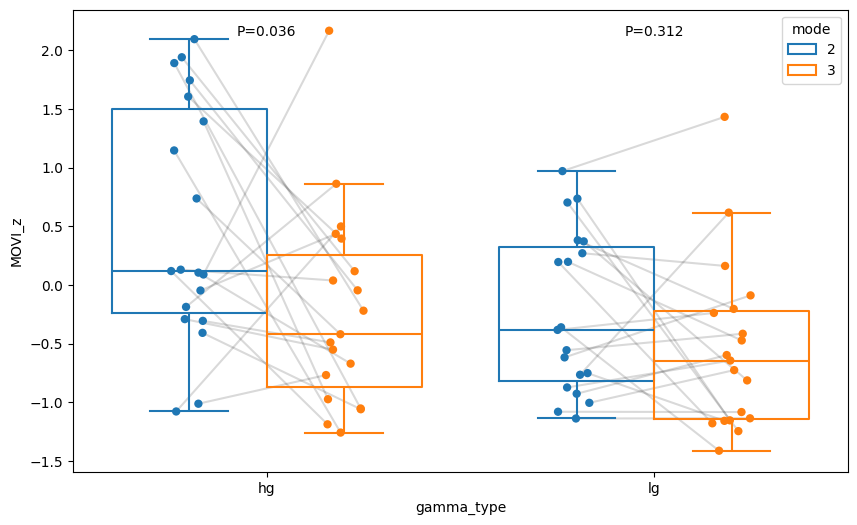

In [239]:
generate_figures(theta_pac_pd_2_3, 'MOVI_z', [2,3])

<Axes: xlabel='gamma_type', ylabel='MOVI'>

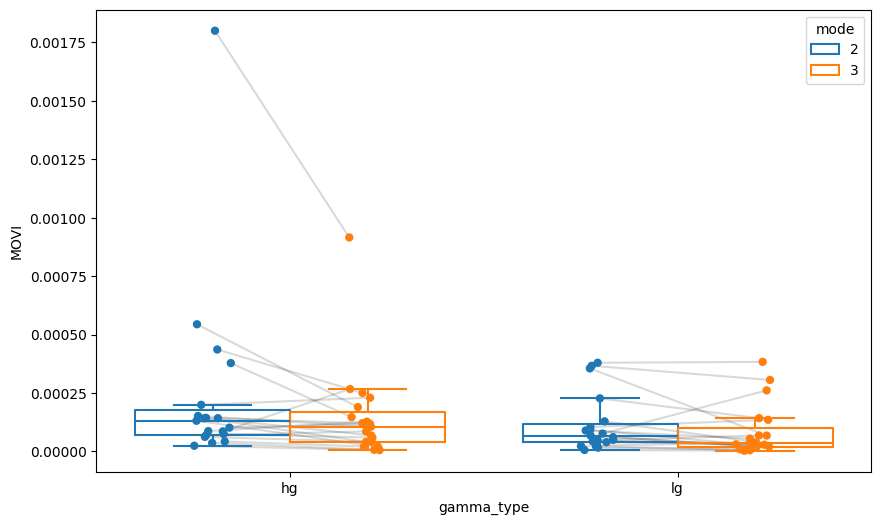

In [224]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
y_val = 'MOVI'
sns.stripplot(data=PAC_SME_df,  x='gamma_type', y=y_val, hue='mode', size=6, dodge=True, ax=ax, legend=False, palette='tab10')
for i in range(0, 4, 2):
    locs1 = ax.get_children()[i].get_offsets()
    locs2 = ax.get_children()[i+1].get_offsets()
    for i in range(locs1.shape[0]):
        x = [locs1[i, 0], locs2[i, 0]]
        y = [locs1[i, 1], locs2[i, 1]]
        ax.plot(x, y, color="black", alpha=0.15)
sns.boxplot(data=PAC_SME_df, x='gamma_type', y=y_val, hue='mode', fliersize=0, ax=ax, fill=False, palette='tab10')


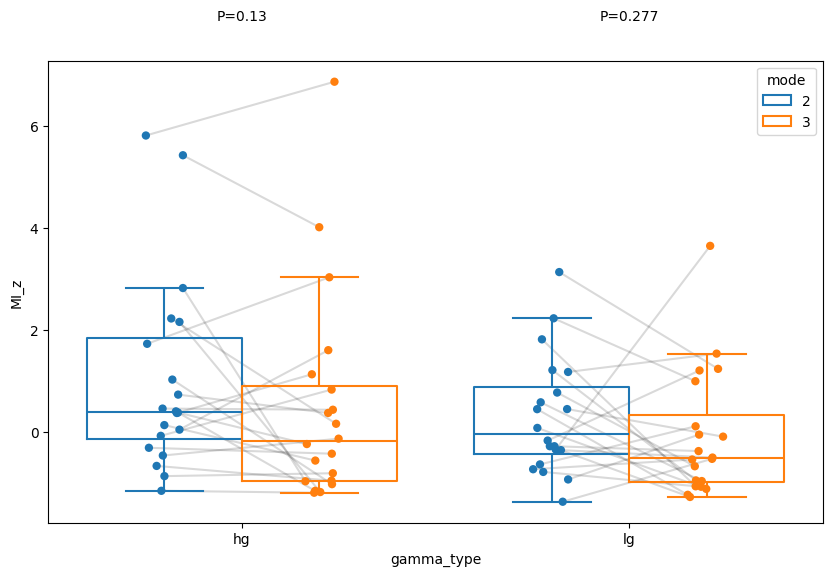

In [25]:
generate_figures(theta_pac_pd_2_3, 'MI_z', [2,3])

In [136]:
def return_MOVI_dict(MOVI_clust, MOVI_notclust):
    
    subjects_both = np.intersect1d(sorted(MOVI_clust.keys()), 
                               sorted(MOVI_notclust.keys()))

    MOVI_dict = {'subj': [], 'clust': [], 'unclust': []}
    for subj in subjects_both:
        MOVI_dict['subj'].append(subj)
        MOVI_dict['clust'].append(MOVI_clust[subj])
        MOVI_dict['unclust'].append(MOVI_notclust[subj])
        
    
    res = wilcoxon(MOVI_dict['clust'], MOVI_dict['unclust'])
    
    print(np.mean(MOVI_dict['clust']))
    print(np.mean(MOVI_dict['unclust']))
    print(res.statistic, res.pvalue)
    

In [137]:
MOVI_clust_hg = dict(np.load('saved_results/hg_MOVI_by_subj_3.npz'))

In [138]:
MOVI_notclust_hg = dict(np.load('saved_results/hg_MOVI_by_subj_2.npz'))

In [139]:
return_MOVI_dict(MOVI_clust_hg, MOVI_notclust_hg)

0.00014854314641970335
0.00024496992729337245
39.0 0.02298736572265625


In [140]:
MOVI_clust_z_hg = dict(np.load('saved_results/hg_MOVI_by_subj_z_3.npz'))
MOVI_notclust_z_hg = dict(np.load('saved_results/hg_MOVI_by_subj_z_2.npz'))

In [141]:
return_MOVI_dict(MOVI_clust_z_hg, MOVI_notclust_z_hg)

-0.21958193150971198
0.5086580263510885
43.0 0.036067962646484375


In [144]:
MOVI_clust_lg = dict(np.load('saved_results/lg_MOVI_by_subj_3.npz'))
MOVI_notclust_lg = dict(np.load('saved_results/lg_MOVI_by_subj_2.npz'))

In [145]:
return_MOVI_dict(MOVI_clust_lg, MOVI_notclust_lg)

8.821999896657658e-05
0.00011582361342795728
45.0 0.044559478759765625


In [142]:
MOVI_clust_z_lg = dict(np.load('saved_results/lg_MOVI_by_subj_z_3.npz'))
MOVI_notclust_z_lg = dict(np.load('saved_results/lg_MOVI_by_subj_z_2.npz'))

In [143]:
return_MOVI_dict(MOVI_clust_z_lg, MOVI_notclust_z_lg)

-0.5443752969153355
-0.2433035580943402
69.0 0.312408447265625
